# Install and Import libs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 4.3 MB/s 
     |████████████████████████████████| 743 kB 41.0 MB/s 


In [3]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
%matplotlib inline

#  Load Train and test data

In [4]:
def read_train_data():
  data_train = pd.read_csv("/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/vlsp_sentiment_train.csv", sep='\t')
  data_train.columns =['Class', 'Data']
  data_aug = pd.read_csv("/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/augment_data/train_augment.csv")
  data_train = pd.concat((data_train, data_aug))

  data_test = pd.read_csv("/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/vlsp_sentiment_test.csv", sep='\t')
  data_test.columns =['Class', 'Data'] 
  return data_train, data_test

data_train, data_test = read_train_data()


In [5]:
print(data_train.shape)
print(data_test.shape)

(21187, 2)
(1050, 2)


# Preprocess data

In [6]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [7]:
def encode_labels(labels):
  result = []
  for label in labels:
      if label == -1:
          result.append([1,0,0])
      elif label == 0:
          result.append([0,1,0])
      else:
          result.append([0,0,1])

  return np.array(result)  

encoded_labels = encode_labels(labels)

In [8]:
reviews_processed = []
unlabeled_processed = [] 

def remove_digits(reviews_input):
  result=[]
  for review in reviews_input:
      review_cool_one = ''.join([char for char in review if char not in digits])
      result.append(review_cool_one)
  return result

reviews_processed = remove_digits(reviews)
unlabeled_processed = [] 

In [9]:
#Use PyVi for Vietnamese word tokenizer

def tokenize(reviews_processed_input):
  result = []
  for review in reviews_processed_input:
      review = ViTokenizer.tokenize(review.lower())
      result.append(review.split())
  return result

word_reviews = tokenize(reviews_processed)
all_words = []
   

In [10]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [12]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [13]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [14]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (21187, 300)
Shape of label train and validation tensor: (21187, 3)


# Build and train model

In [15]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding

def build_embedding_layer(word_index):

  word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/vi-model-CBOW.bin', binary=True)


  vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
  embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
  for word, i in word_index.items():
      if i>=MAX_VOCAB_SIZE:
          continue
      try:
          embedding_vector = word_vectors[word]
          embedding_matrix[i] = embedding_vector
      except KeyError:
          embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

  del(word_vectors)


  return Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
  


embedding_layer = build_embedding_layer(word_index)

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, Permute, Attention, GlobalAveragePooling1D
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, Concatenate, Reshape, ReLU, BatchNormalization
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.metrics import Precision
from keras.metrics import Recall



def build_model(sequence_length, embedding_layer_input): 
  drop = 0.25
  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer_input(inputs)

  # Use Bidirectional LSTM
  bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)

  # BiLSTM sẽ trả về các hidden state theo chiều xuôi và ngược nối tiếp nhau.
  # Để đưa vào Attention, ta sẽ cần tách 2 phần này ra
  bilstm = Reshape((MAX_SEQUENCE_LENGTH, -1, 2))(bilstm)
  permute_bilstm = Permute((3,1,2))(bilstm)

  # Attention layer
  # Input là chuỗi hidden xuôi và ngược
  # Output là vector context
  selfattn = Attention()([permute_bilstm[:,0], permute_bilstm[:,1]])

  # Kết hợp vector context với vector hidden state xuôi
  # Tại vị trí mỗi từ sẽ bao gồm feature + context của từ đó
  input_layer = Concatenate()([permute_bilstm[:,0], selfattn])

  # Tiếp theo, chúng ta cần một tầng FC để kết hợp các feature ban đầu của từ với context của nó
  input_layer = Dense(256, activation="tanh")(input_layer)

  # Có thể dùng layer này để reduce vector feature của 1 từ thành 1 giá trị
  # input_layer = Dense(1, activation="tanh")(input_layer)

  flatten = Flatten()(input_layer)

  # Có thể dùng thêm dropout hoặc batchnormalization
  # flatten = Dropout(drop)(flatten)

  output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(flatten)

  # This creates a model that includes
  lstmModel = Model(inputs, output)

  adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  lstmModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', Precision(), Recall()])
  lstmModel.summary()
  return lstmModel

model = build_model(data.shape[1], embedding_layer)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 400)     4000000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 300, 256)     541696      ['embedding[0][0]']              
                                                                                                  
 reshape (Reshape)              (None, 300, 128, 2)  0           ['bidirectional[0][0]']          
                                                                                              

# INput the same
# 300x400
Bidrectional:  di xuoi, di nguoi, roi combine 2 vector 128 x2

In [17]:
### IF YOU HAVE MODEL WEIGHT AND WANNA LOAD IT
# model.load_weights("//content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/LSTM/bilstm_attention.h5")

ValueError: ignored

In [18]:
history = model.fit(data, labels, validation_split=0.2,
          epochs=100, batch_size=256, callbacks=callbacks_list, shuffle=True, verbose=1)

Epoch 1/100
67/67 [==============================] - 35s 421ms/step - loss: 0.6386 - accuracy: 0.7439 - precision: 0.7953 - recall: 0.6730 - val_loss: 0.3223 - val_accuracy: 0.8898 - val_precision: 0.9042 - val_recall: 0.8664
Epoch 2/100
67/67 [==============================] - 27s 396ms/step - loss: 0.4225 - accuracy: 0.8444 - precision: 0.8719 - recall: 0.8119 - val_loss: 0.3122 - val_accuracy: 0.8841 - val_precision: 0.8949 - val_recall: 0.8719
Epoch 3/100
67/67 [==============================] - 26s 394ms/step - loss: 0.3311 - accuracy: 0.8852 - precision: 0.9021 - recall: 0.8652 - val_loss: 0.3554 - val_accuracy: 0.8761 - val_precision: 0.8877 - val_recall: 0.8620
Epoch 4/100
67/67 [==============================] - 26s 393ms/step - loss: 0.2451 - accuracy: 0.9245 - precision: 0.9327 - recall: 0.9139 - val_loss: 0.3520 - val_accuracy: 0.8903 - val_precision: 0.8924 - val_recall: 0.8886
Epoch 5/100
67/67 [==============================] - 26s 395ms/step - loss: 0.1595 - accuracy: 0

#Plot data

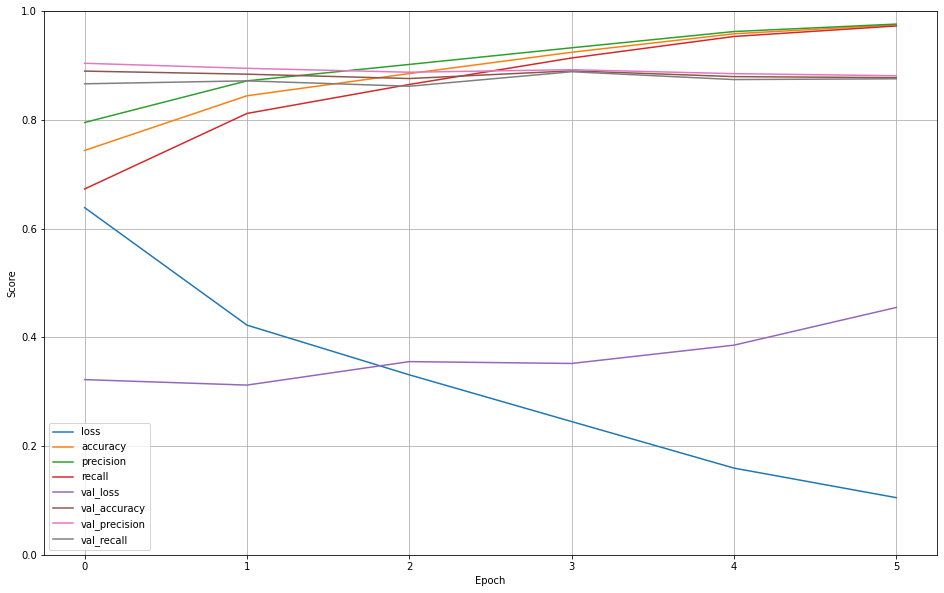

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def show_graph(history):
  pd.DataFrame(history.history).plot(figsize = (16, 10))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.show()

show_graph(history)

In [20]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [21]:
encoded_labels_test = encode_labels(labels_test)

In [22]:
reviews_processed_test = remove_digits(reviews_test)
unlabeled_processed_test = [] 

In [23]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [24]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [25]:
print('Shape of X train and X validation tensor:',data_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 300)
Shape of label train and validation tensor: (1050, 3)


In [26]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 2s 57ms/step - loss: 1.1956 - accuracy: 0.6781 - precision: 0.6841 - recall: 0.6600


# Performance của Model

In [27]:
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (model.metrics_names[3], score[3]*100))



loss: 119.56%
accuracy: 67.81%
precision: 68.41%
recall: 66.00%


In [28]:
model.save_weights("/content/drive/MyDrive/Learning/Natural Language Processing/Exercises/Bai Tap Lon/LSTM/bilstm_attention.h5")

# Test model

## Review 5*

In [29]:
test = "Áo hơi mỏng nhưng rất đẹp hình thêu các thứ rất đẹp còn 1 vài chỗ có chỉ thừa phần 2 túi áo nên làm kiểu zip chất lương hơn tí hoặc có thể k cần zip cũng đc phần bo chun ống tay và cổ áo cần cải thiện thêm. Nói chung với giá đc sale xuống và mình dùng voucher nữa nên như này mình cũng hài lòng rồi"

reviews_processed_test = []

review_not_contain_digit = ''.join([char for char in test if char not in digits])
reviews_processed_test.append(review_not_contain_digit)

word_reviews_test = tokenize(reviews_processed_test)


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_test)
sequences_train = tokenizer.texts_to_sequences(word_reviews_test)

sampleToPredit = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

class_names = ["Negative", "Neutral", "Positive"]
pre = model.predict(sampleToPredit)
print(pre)
print(class_names[np.argmax(pre)])

[[1.1160551e-02 4.4610386e-04 9.8839337e-01]]
Positive


## Review 3*

In [30]:
test = "Áo mỏng hơn so với mình nghĩ.... Ko xứng đáng với giá 450k sz L mà như M vậy"

reviews_processed_test = []

review_not_contain_digit = ''.join([char for char in test if char not in digits])
reviews_processed_test.append(review_not_contain_digit)


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_test)
sequences_train = tokenizer.texts_to_sequences(word_reviews_test)

sampleToPredit = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

pre = model.predict(sampleToPredit)
print(pre)
print(class_names[np.argmax(pre)])

[[1.1160551e-02 4.4610386e-04 9.8839337e-01]]
Positive


## Review 1*

In [31]:
test = "Như cái rẻ lau chân chán kinh khủng, mua phí tiền.mặc được chết liền"

reviews_processed_test = []

review_not_contain_digit = ''.join([char for char in test if char not in digits])
reviews_processed_test.append(review_not_contain_digit)


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews_test)
sequences_train = tokenizer.texts_to_sequences(word_reviews_test)

sampleToPredit = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)

pre = model.predict(sampleToPredit)
print(pre)
print(class_names[np.argmax(pre)])

[[1.1160551e-02 4.4610386e-04 9.8839337e-01]]
Positive
